In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import sys
import warnings
warnings.filterwarnings('ignore')
sys.path.append('..')
from utils import featurize, update_vars
import scanpy as sc
from modules.vae import JointVAE
from torch import optim
from modules.losses import Loss
from early_stopping import EarlyStopping
from tqdm import tqdm
import numpy as np
import seaborn as sns
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import scale
from scipy.stats import spearmanr
import squidpy as sq
import math
from leiden_clustering import LeidenClustering
from anndata import AnnData
import pandas as pd
from sklearn.decomposition import PCA
from utils import train_test_split
from modules.losses import Metrics
from modules.losses import LossFunctions
from plotting import plot_latent
from utils import euclidean_distance
from plotting import plot_latent
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
import re, seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
from anndata import AnnData
import uniport as up
import cuml
assert torch.cuda.is_available()
torch.manual_seed(1)
torch.cuda.manual_seed(1)
np.random.seed(1)

In [5]:
tissue = 'Breast'
adata = sc.read_10x_h5(f'/ix/hosmanbeyoglu/kor11/CytAssist/{tissue}/GEX_PEX/filtered_feature_bc_matrix.h5', gex_only=False)
visium_ = sc.read_visium(path=f'/ix/hosmanbeyoglu/kor11/CytAssist/{tissue}/GEX_PEX/')
adata.uns['spatial'] = visium_.uns['spatial']
adata.obsm['spatial'] = visium_.obsm['spatial']
adata.obsm['spatial'] = adata.obsm['spatial'].astype(float)
adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)
adata = adata[adata.obs["pct_counts_mt"] < 20]
adata = adata[:, adata.var["mt"] == False]
pdata = adata[:, adata.var.feature_types=='Antibody Capture']
adata = adata[:, adata.var.feature_types=='Gene Expression']
pdata.var["isotype_control"] = (pdata.var_names.str.startswith("mouse") | pdata.var_names.str.startswith("rat") | pdata.var_names.str.startswith("HLA"))
pdata = pdata[:, pdata.var.isotype_control==False]
adata.layers['counts'] = adata.X
pdata.layers['counts'] = pdata.X
adata.var_names_make_unique()
adata.shape, pdata.shape

((4169, 18074), (4169, 30))

In [6]:
# https://cellxgene.cziscience.com/collections/4195ab4c-20bd-4cd3-8b3d-65601277e731

In [7]:
# adata = sc.read_visium(path='/ix/hosmanbeyoglu/kor11/CytAssist/Breast/GEX_PEX')
adata6 = sc.read_h5ad('/ix/hosmanbeyoglu/kor11/CytAssist/Breast/visium/patient_6.h5ad')

In [8]:
adata.var_names_make_unique()
adata6.var_names_make_unique()

adata.obsm['spatial'] = adata.obsm['spatial'].astype(float)
adata6.obsm['spatial'] = adata6.obsm['spatial'].astype(float)

In [9]:
adata.obs['source'] = 'Breast CytAssist (Ref)'
adata.obs['domain_id'] = 0
adata.obs['source'] = adata.obs['source'].astype('category')
adata.obs['domain_id'] = adata.obs['domain_id'].astype('category')

adata6.obs['source'] = 'Breast Sample 6'
adata6.obs['domain_id'] = 1
adata6.obs['source'] = adata6.obs['source'].astype('category')
adata6.obs['domain_id'] = adata6.obs['domain_id'].astype('category')

In [10]:
adata6.var_names = adata6.var.feature_name.values

In [11]:
adata_cm = AnnData.concatenate(adata, adata6, join='inner')

In [12]:
sc.pp.normalize_total(adata_cm)
sc.pp.log1p(adata_cm)
sc.pp.highly_variable_genes(adata_cm, n_top_genes=5000, inplace=False, subset=True)
up.batch_scale(adata_cm)

In [13]:
adata = adata_cm[adata_cm.obs.domain_id==0]
adata6 = adata_cm[adata_cm.obs.domain_id==1]

In [14]:
adata.shape, adata6.shape

((4169, 5000), (3037, 5000))

In [15]:
# adata_cm = AnnData.concatenate(adata, adata6, join='inner')
# adatax = up.Run(name=tissue, adatas=[adata, adata6], adata_cm=adata_cm, lambda_s=1.0, ref_id=1)

In [18]:
# plt.rcParams['figure.figsize'] = [7, 7]
# red = cuml.UMAP(
#     n_components=2,
#     n_neighbors=20,
#     min_dist=.1,
# )
# red.fit(adatax.obsm['latent'])
# plot_data = red.transform(adatax.obsm['latent'])
# sns.scatterplot(plot_data[:, 0], plot_data[:, 1], hue=adatax.obs.source, edgecolor='black', s=65)
# plt.show()

In [72]:
def project(ix):
    adata3 = sc.read_h5ad(f'/ix/hosmanbeyoglu/kor11/CytAssist/Breast/visium/patient_{ix}.h5ad')
    adata3.obs['source'] = f'Breast Sample {ix}'
    adata3.obs['domain_id'] = ix
    adata3.obs['source'] = adata3.obs['source'].astype('category')
    adata3.obs['domain_id'] = adata3.obs['domain_id'].astype('category')

    sc.pp.normalize_total(adata3)
    sc.pp.log1p(adata3)
    up.batch_scale(adata3)
    
    adata3.var_names = adata3.var.feature_name.values
    
    adata_cm = AnnData.concatenate(adata3, adata, join='inner')
    adata_new = up.Run(name=tissue, adatas=[adata3, adata], adata_cm =adata_cm, lambda_s=1.0, out='project', ref_id=1)
    adata3.obsm['latent'] = adata_new[adata_new.obs.domain_id==ix].obsm['project']
    adata3.obsm['project'] = adata_new[adata_new.obs.domain_id==ix].obsm['project']
    # adata_new = adata_new.concatenate(adata3, join='inner')
    return adata3

In [ ]:
adata3 = sc.read_h5ad(f'/ix/hosmanbeyoglu/kor11/CytAssist/Breast/visium/patient_{ix}.h5ad')
adata3.obs['source'] = f'Breast Sample {ix}'
adata3.obs['domain_id'] = ix
adata3.obs['source'] = adata3.obs['source'].astype('category')
adata3.obs['domain_id'] = adata3.obs['domain_id'].astype('category')

sc.pp.normalize_total(adata3)
sc.pp.log1p(adata3)
up.batch_scale(adata3)

adata3.var_names = adata3.var.feature_name.values

adata_cm = AnnData.concatenate(adata3, adata, join='inner')
adata_new = up.Run(name=tissue, adatas=[adata3, adata], adata_cm =adata_cm, lambda_s=1.0, out='project', ref_id=1)
adata3.obsm['latent'] = adata_new[adata_new.obs.domain_id==ix].obsm['project']
adata3.obsm['project'] = adata_new[adata_new.obs.domain_id==ix].obsm['project']

In [73]:
adata_out = [project(i) for i in tqdm(range(1, 11))] 

100%|██████████| 10/10 [09:20<00:00, 56.10s/it]


In [77]:
AnnData.concatenate(*adata_out[:2]).obs.domain_id.unique()

[1, 2]
Categories (2, int64): [1, 2]

In [103]:
adata_cyt = up.Run(name=tissue, adatas=[adata], adata_cm =adata, lambda_s=1.0, out='project', ref_id=1)
adata_cyt.obsm['latent'] = adata_cyt.obsm['project']

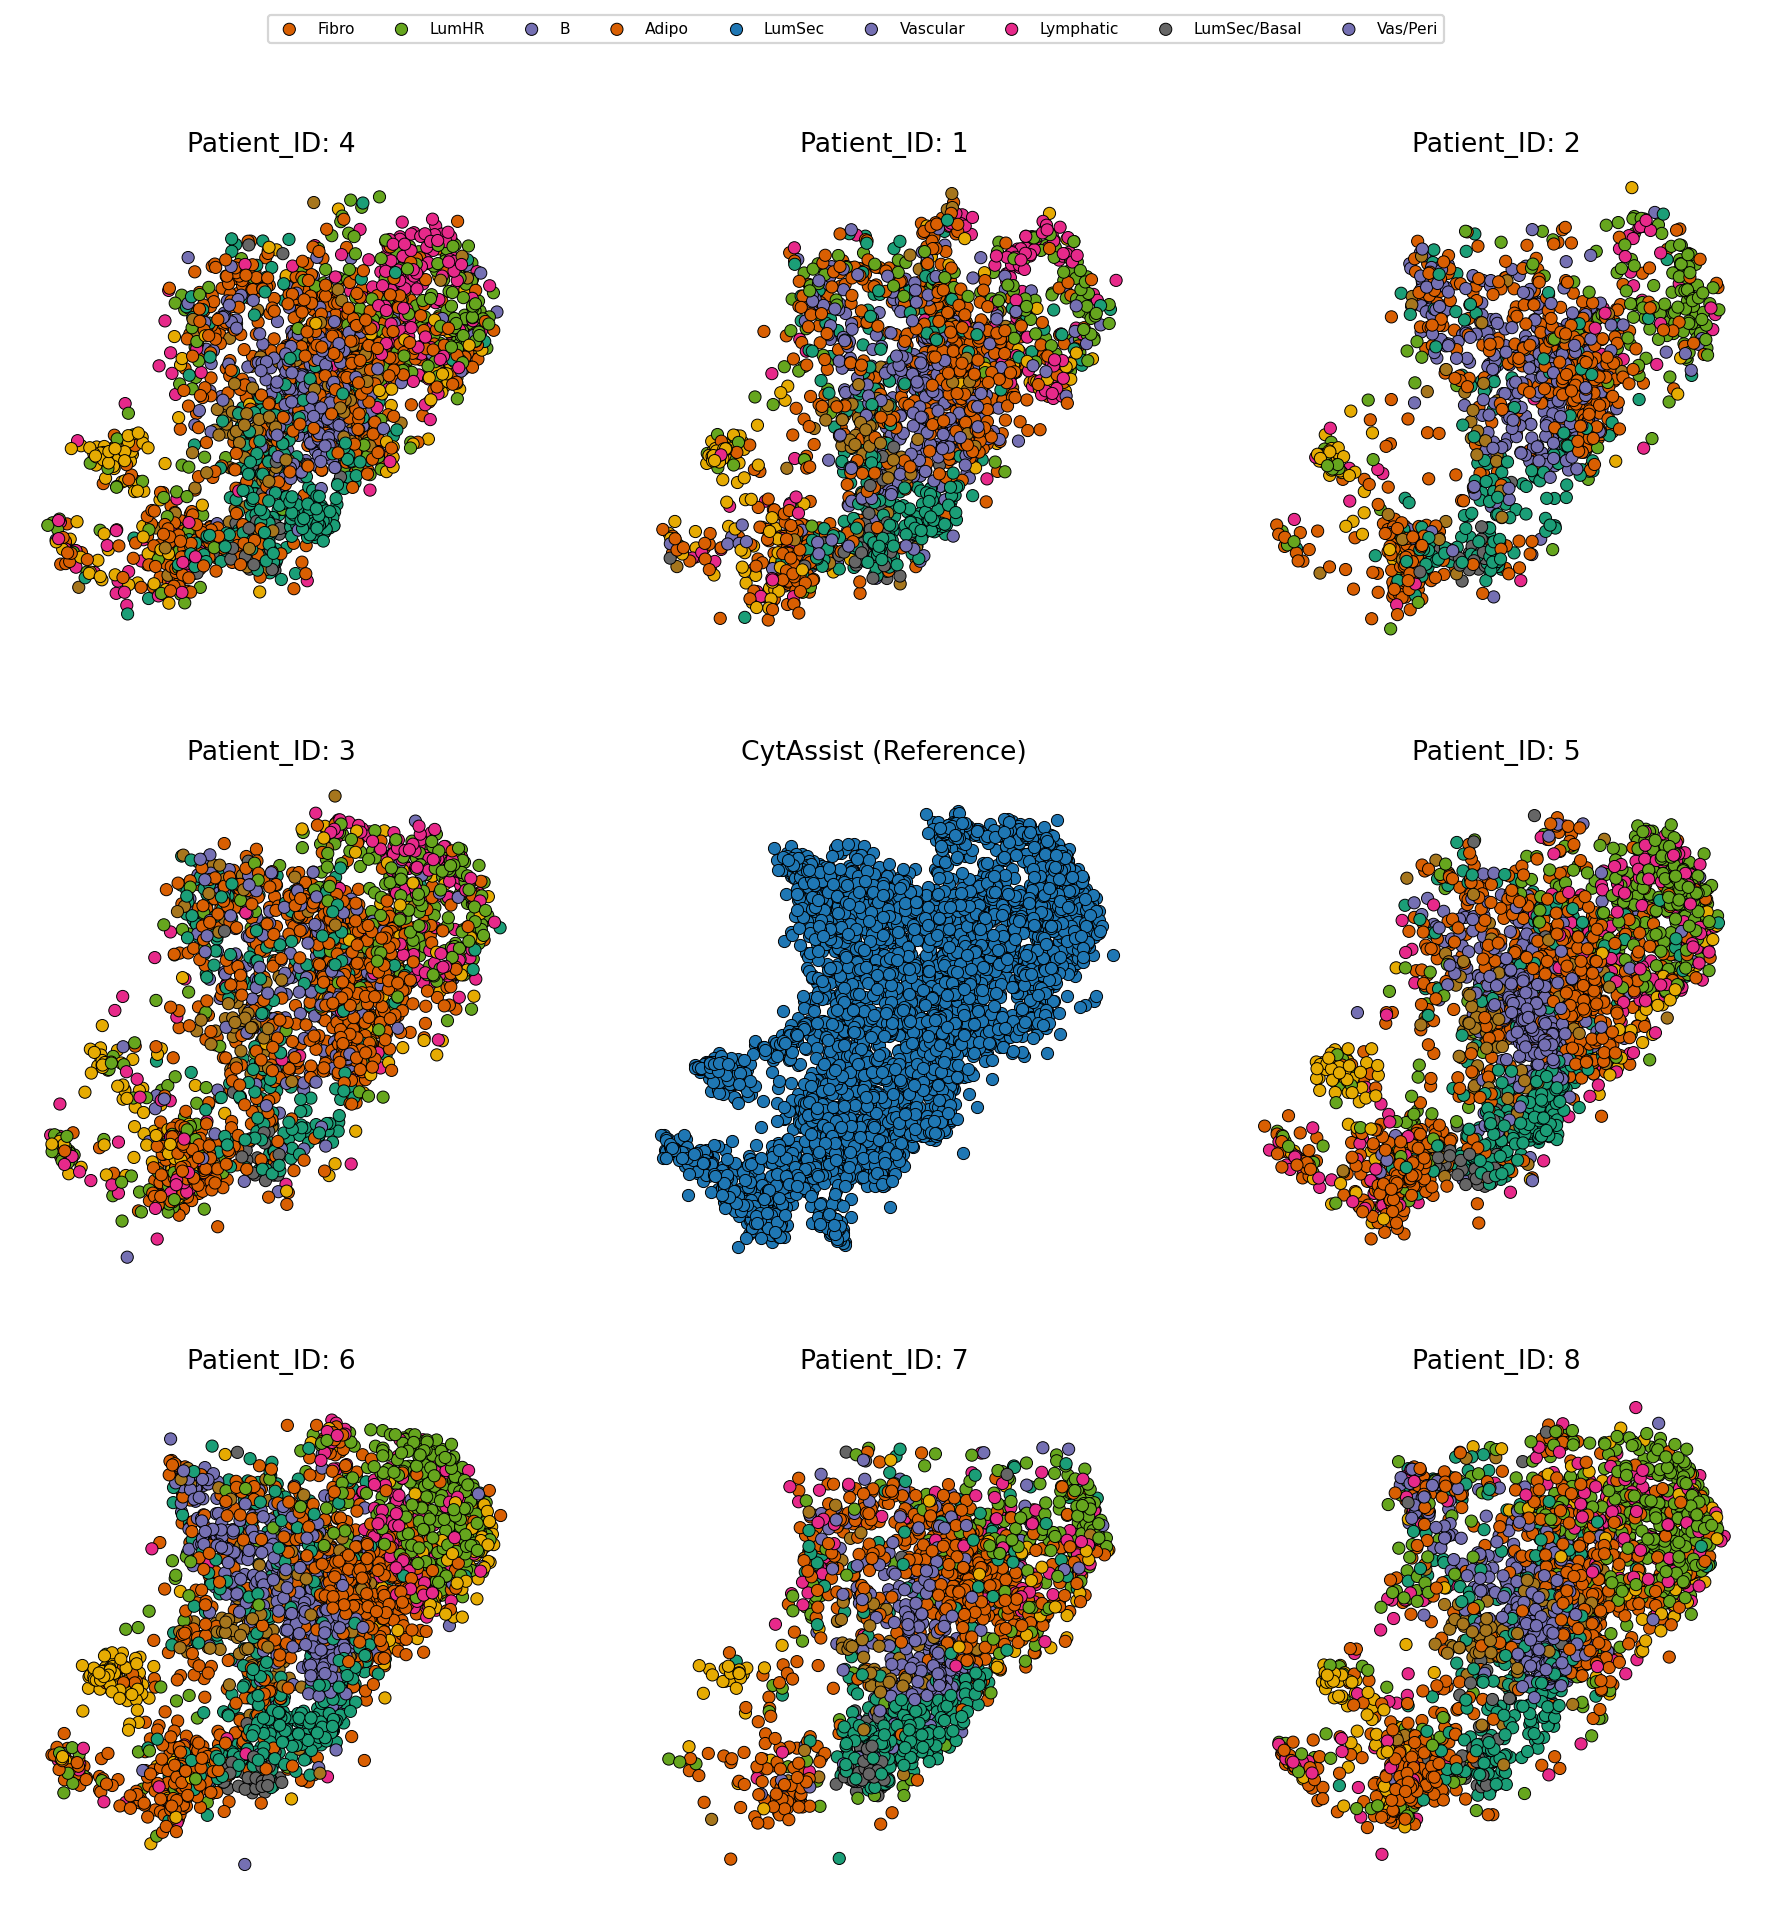

In [210]:
adata_all = AnnData.concatenate(*adata_out+[adata_cyt])
red = cuml.UMAP(
    n_components=2,
    n_neighbors=100,
    min_dist=.1,
)

red.fit(adata_all[adata_all.obs.domain_id==0].obsm['latent'])

f, axs = plt.subplots(3, 3, figsize=(14, 14), dpi=160, sharey=True, sharex=True)

axs = axs.flatten()

for ix, ax in enumerate(axs):
    
    if ix == 0:
        ax = axs[4]
        
    if ix == 4:
        ax = axs[0]
    
    targets = adata_all[adata_all.obs.domain_id == ix]

    plot_data = red.transform(targets.obsm['project'])
    scatter = sns.scatterplot(plot_data[:, 0], plot_data[:, 1], hue=targets.obs.author_cell_type, s=30, ax=ax, legend=False, edgecolor='black', palette='Dark2')
    
    if ix == 0:
        ax.set_title(f'CytAssist (Reference)')
    else:
        ax.set_title(f'Patient_ID: {ix}')
        
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    
fig = plt.gcf()
fig.legend(scatter, labels=[i.split('-')[-1] for i in targets.obs.author_cell_type.unique()], bbox_to_anchor=(0.5, 0.95), loc='upper center', ncols=9, fontsize=7)
plt.show()